In [15]:
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Activation
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Dropout

In [27]:
# If using AWS server, set this to True to change the file data's path
aws = False

if aws:
    csv_path = "/home/carnd/Udacity-Self-Driving-Car-NanoDegree/p3-behavioural-cloning/carnd-behavioral-cloning-p3/data/driving_log.csv"
    image_path = "/home/carnd/Udacity-Self-Driving-Car-NanoDegree/p3-behavioural-cloning/carnd-behavioral-cloning-p3/data/data/IMG"
else:
    csv_path = "D:\SDC\p3-Behavioural-Cloning\p3-behavorial-cloning\data\data\driving_log.csv"
    image_path = "D:\SDC\p3-Behavioural-Cloning\p3-behavorial-cloning\data\data\IMG\\"

lines = []
with open(csv_path) as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None)
    for line in reader:
        lines.append(line)

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\SDC\\p3-Behavioural-Cloning\\p3-behavorial-cloning\\data\\data\\driving_log.csv'

In [39]:
import os
print(os.getcwd())

for a, b, c in os.walk("."):
    for stuff in a:
        print('{}'.format(a))

# csv_path = r"D:\SDC\p3-Behavioural-Cloning\p3-behavorial-cloning\data\data\driving_log.csv"
# import pandas as pd
# csv = pd.read_csv(csv_path)

/home/carnd/Udacity-Self-Driving-Car-NanoDegree/p3-behavioural-cloning/carnd-behavioral-cloning-p3
.
./__MACOSX
./__MACOSX
./__MACOSX
./__MACOSX
./__MACOSX
./__MACOSX
./__MACOSX
./__MACOSX
./__MACOSX
./__MACOSX
./__MACOSX/data
./__MACOSX/data
./__MACOSX/data
./__MACOSX/data
./__MACOSX/data
./__MACOSX/data
./__MACOSX/data
./__MACOSX/data
./__MACOSX/data
./__MACOSX/data
./__MACOSX/data
./__MACOSX/data
./__MACOSX/data
./__MACOSX/data
./__MACOSX/data
./__MACOSX/data/IMG
./__MACOSX/data/IMG
./__MACOSX/data/IMG
./__MACOSX/data/IMG
./__MACOSX/data/IMG
./__MACOSX/data/IMG
./__MACOSX/data/IMG
./__MACOSX/data/IMG
./__MACOSX/data/IMG
./__MACOSX/data/IMG
./__MACOSX/data/IMG
./__MACOSX/data/IMG
./__MACOSX/data/IMG
./__MACOSX/data/IMG
./__MACOSX/data/IMG
./__MACOSX/data/IMG
./__MACOSX/data/IMG
./__MACOSX/data/IMG
./__MACOSX/data/IMG
./data
./data
./data
./data
./data
./data
./data/IMG
./data/IMG
./data/IMG
./data/IMG
./data/IMG
./data/IMG
./data/IMG
./data/IMG
./data/IMG
./data/IMG
./.ipynb_checkpoi

In [26]:
print(lines[0])

IndexError: list index out of range

### Parse CSV file

In [24]:
images = []
measurements = []
for line in tqdm(lines):
    source_path = line[0]
    print('source_path\t', source_path)
    filename = source_path.split('/')[-1]
    print('filename\t', filename)
    image_path_list = image_path + filename
    print('image_path_list\t', image_path_list)
    image = cv2.imread(image_path_list)
    print(image)
    break
    images.append(image)
    measurement = float(line[3])
    measurements.append(measurement)

  0%|          | 0/8036 [00:00<?, ?it/s]

source_path	 IMG/center_2016_12_01_13_30_48_287.jpg
filename	 center_2016_12_01_13_30_48_287.jpg
image_path_list	 /home/carnd/Udacity-Self-Driving-Car-NanoDegree/p3-behavioural-cloning/carnd-behavioral-cloning-p3/data/data/IMGcenter_2016_12_01_13_30_48_287.jpg
None


### Flip Image and Steering Angle

In [5]:
augmented_images, augmented_measurements = [], []
for image, measurement in zip(images, measurements):
    augmented_images.append(image)
    augmented_measurements.append(measurement)
    augmented_images.append(cv2.flip(image, 1))
    augmented_measurements.append(measurement*-1.0)

### Plot Histogram of Steering Angle Distribution

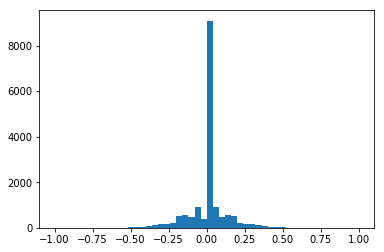

In [6]:
plt.hist(augmented_measurements, 50)
plt.show()

### Construct Model

In [10]:
batch_size = 128

# X_train = np.array(augmented_images)
# y_train = np.array(augmented_measurements)

X_train = np.array(images)
y_train = np.array(measurements)

# barebones model
model = Sequential()
# model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
model.add(Convolution2D(nb_row=5, nb_col=5, nb_filter=16, input_shape=(160,320,3)))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
# model.add(Dense(84))
# model.add(Activation('relu'))
model.add(Dense(1))

# model = Sequential()
# model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160,320,3)))
# model.add(Convolution2D(nb_row=3, nb_col=3, nb_filter=32))
# model.add(MaxPooling2D(strides=None))
# model.add(Dropout(0.5))
# model.add(Activation('relu'))
# model.add(Flatten())
# model.add(Dense(128))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Dense(84))
# model.add(Dense(1))

### Train, Validate, and Save Model

In [11]:
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=1, batch_size=batch_size)

model.save('model-v1.h5')

ValueError: Error when checking model input: expected convolution2d_input_3 to have 4 dimensions, but got array with shape (8036, 1)